# Waste Classification - Fine-Tuning a ResNet34 Model for Waste Classification
This notebook covers the complete workflow for fine-tuning a ResNet18 model to classify waste into categories such as recyclable or organic. It begins with setting up the environment, including checking for CUDA availability, and loading the dataset from a specified directory. The dataset is then prepared by transforming images and splitting them into training and validation sets using `SubsetRandomSampler`.

The core of the notebook involves fine-tuning a pretrained ResNet18 model, leveraging transfer learning to adapt the model to the waste classification task. The training process includes setting up the data loaders, defining the loss function and optimizer, and training the model over a specified number of epochs while monitoring its performance on the validation set.

After training, the notebook evaluates the model's performance by making predictions on the validation set, calculating accuracy, and visualizing sample predictions. This provides insights into how well the model can differentiate between the waste categories, helping to assess its effectiveness in real-world scenarios.



## Import all required packages

In [1]:
import torch
import numpy as np
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import matplotlib.pyplot as plt

Checking if CUDA is available for trainig the model using GPU.

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


## Data Preparation

Setting up directory path for where the dataset is stored. `torchvision.datasets.ImageFolder` is used to load the dataset from the specified directory. To provide a summary of the dataset, the list of class names, the number of samples per class, the total number of samples, and details about the first sample are displayed. This summary helps to understand the dataset's structure and distribution before proceeding with further analysis or model training.

In [3]:
TRAIN_DIR = "../DATASET/TRAIN/"
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR)
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Classes: ['O', 'R']
Class count: 12565, 9999
Samples: 22564
First sample: ('../DATASET/TRAIN/O\\O_1.jpg', 0)


`SubsetRandomSampler`: This is a PyTorch class used to sample data from a dataset based on provided indices. It ensures that the batches returned are from the specified subset of data (training or validation) and that the samples are randomly selected.

In [4]:
# Shuffling and Splitting Train data into train and valid data
valid_size = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Creating Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


## Preprocessing and Data Augmentation
`ImageFolder` loads our data using the `PIL` package. We need to convert it into tensors. Pre-processing will be done using `torchvision.transforms`.
1) Resizing: Ensure all images are of the same size, which is often reuqired for CNN
2) Normalization: Normalize images to have a mean and standard deviation of O and 1 respectively. Ensure the data is on the same scale as what the prer-trained model expects.
3) Random Horizontal Flip: Adds data augmentation to improve model generalization.
4) Random Rotation: Helps in generalizaing by rotating images randomly within a specified range.
5) Color Jitter: Slightly adjusts bightness, contrast, saturation, and hue to make model more robust


In [5]:
IMAGE_SIZE = (64, 64)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)

Working with batches of data using `dataloader`

In [6]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    sampler=train_sampler,  # indicates which sampler to use to get the batches of data
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, 
    sampler=valid_sampler,
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

## Preparing the test dataset
Only resize and normalization transformation arre applied for the test data and not any data augmentation.

In [7]:
TEST_DIR = "../DATASET/TEST/"
data_transforms_test = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=data_transforms_test)

In [8]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

## Using Transfer Learning with ResNet34
we leverage transfer learning by utilizing a pre-trained `ResNet34` model, which has been trained on a large dataset. This approach allows us to take advantage of the model's learned features without training from scratch. We begin by loading the pre-trained `ResNet34` model and then freeze all of its layers to prevent their weights from being updated during training. This is achieved by setting `requires_grad` to `False` for all model parameters.

Next, we customize the model for binary classification by modifying its final classification layer. The original ResNet34 model's last layer is a fully connected layer that outputs 1000 values, corresponding to the number of classes in the ImageNet dataset. We replace this layer with a new set of layers: a fully connected layer with 250 output features, followed by a ReLU activation function, and another fully connected layer that outputs 2 values (one for each class in our binary classification task).

Finally, we integrate these new layers into the model, ensuring that only the last two layers of the network will be fine-tuned during training. This approach efficiently adapts the pre-trained model to our specific task while retaining the beneficial features learned from the large dataset.

In [9]:
# Load a pre-trained resnet34
model = models.resnet34(pretrained=True)

# Freeze all layers parameter
for param in model.parameters(): 
    param.requires_grad = False

# List the last classification layer, a fully connected layer outputting 1000 values
list(model.named_children())[-1]
num_features = model.fc.in_features

new_layers = nn.Sequential(
    nn.Linear(num_features,250),
    nn.ReLU(),
    nn.Linear(250,2)
)

model.fc = new_layers

c:\Users\User\miniconda3\envs\waste_org\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\waste_org\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training Set Up
To train our model, we need to define the loss function and optimizer. The following code sets up a training procedure using PyTorch:

1) Training Function:

- **Function Definition:**
 The trainer function manages the training and validation process. It takes the model, loss function, optimizer, data loaders, device, number of epochs, and verbosity flag as inputs.
- **Training Loop:**
The model is set to training mode, and for each batch in the training loader, we perform a forward pass, calculate the loss, backpropagate the gradients, and update the model parameters.
Training accuracy is computed by comparing the predicted labels to the true labels.
- **Validation Loop:**
The model is set to evaluation mode, and for each batch in the validation loader, we perform a forward pass and compute the loss without updating the model parameters.
Validation accuracy is calculated similarly to training accuracy.
- **Progress Reporting:** If verbose is set to True, the function prints the training and validation accuracy after each epoch.


In [10]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y.long())  # Ensure target labels are Long
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            _, y_hat_labels = torch.max(y_hat, 1)
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y.long())  # Ensure target labels are Long
                valid_batch_loss += loss.item()
                _, y_hat_labels = torch.max(y_hat, 1)
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}

2) Loss Function and Optimizer:

- **Loss Function:** We use nn.CrossEntropyLoss(), which is suitable for multi-class classification problems.
- **Optimizer:** We choose optim.Adam() with a learning rate of 0.001, which adapts the learning rate based on the gradients and helps in optimizing the model.

In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

results = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=10)

Epoch 1: Train Accuracy: 0.80 Valid Accuracy: 0.82
Epoch 2: Train Accuracy: 0.82 Valid Accuracy: 0.83
Epoch 3: Train Accuracy: 0.83 Valid Accuracy: 0.83
Epoch 4: Train Accuracy: 0.83 Valid Accuracy: 0.84
Epoch 5: Train Accuracy: 0.84 Valid Accuracy: 0.84
Epoch 6: Train Accuracy: 0.84 Valid Accuracy: 0.84
Epoch 7: Train Accuracy: 0.84 Valid Accuracy: 0.84
Epoch 8: Train Accuracy: 0.84 Valid Accuracy: 0.83
Epoch 9: Train Accuracy: 0.85 Valid Accuracy: 0.84
Epoch 10: Train Accuracy: 0.84 Valid Accuracy: 0.85


## Saving the trained model

In [13]:
torch.save(model.state_dict(), '../model_waste.pt')

## Evaluating the model with test data

This code evaluates the trained model on a test dataset by calculating the test loss and accuracy for each class. It accumulates the total loss and counts correct predictions per class. After iterating through the test data, it prints the average test loss, the accuracy for each class, and the overall test accuracy of the model.

In [12]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

#defining classes

classes=['O','R']

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.405638

Test Accuracy of     O: 97% (43/44)
Test Accuracy of     R: 80% (29/36)

Test Accuracy (Overall): 90% (72/80)


## Using the model to make perdiction

This code loads a pre-trained ResNet34 model, modifies it for binary classification, and loads weights from the previous trained model. It then prepares an image for prediction, runs it through the model, and prints the predicted class.

In [7]:
# Load a pre-trained resnet34
model = models.resnet34(pretrained=True)

# Freeze all layers parameter
for param in model.parameters(): 
    param.requires_grad = False

# List the last classification layer, a fully connected layer outputting 1000 values
list(model.named_children())[-1]
num_features = model.fc.in_features

new_layers = nn.Sequential(
    nn.Linear(num_features,250),
    nn.ReLU(),
    nn.Linear(250,2)
)

model.fc = new_layers

# Load the state_dict
model.load_state_dict(torch.load('../model_waste.pt'))

# Set to evaluation mode if you plan to use it for inference
model.eval()

c:\Users\User\miniconda3\envs\waste_org\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\waste_org\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Making prediction on a specific image.

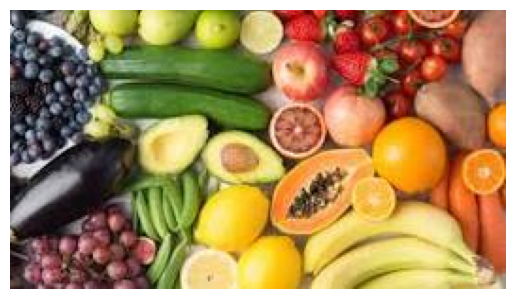

Predicted class: Organic


In [6]:
IMAGE_SIZE = 64

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and display the image
image = Image.open('../organic_sample.jpeg')  # Replace with the path to your image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Preprocess the Image
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Make prediction
with torch.no_grad():  # Disable gradient calculation
    output = model(image)
    _, predicted = torch.max(output, 1)

# Interpret the prediction

classes=['Organic','Recyclable']
predicted_class = classes[predicted.item()]

print(f'Predicted class: {predicted_class}')

